# An Introduction to Dynamic Mode Decomposition (DMD)

This notebook introduces the basics of Dynamic Mode Decomposition (DMD). Some other great tools for learning are:

> [pyrunner: Dynamic Mode Decomposition in Python](http://www.pyrunner.com/weblog/2016/07/25/dmd-python/)

> [Data Driven Science and Engineering](https://www.cambridge.org/core/books/datadriven-science-and-engineering/77D52B171B60A496EAFE4DB662ADC36E) by Steven L. Brunon and J. Nathan Kutz

## Goal:

The goal of DMD is to approximate the leading eigencomposition of (high dimensional) linear operator $A \in \mathbb{C}^{n \times n}$ where $X'=AX$ to find spacial temporal coherant structures of a given (possibly non-linear) system. Simply put:
> "DMD converts a dynamical system into a superposition of modes whose dynamics are governed by eigenvalues." -[pyrunner](http://www.pyrunner.com/weblog/2016/07/25/dmd-python/)

## Inputs to DMD

The following data pair $X$ and $X'$ contain snapshots of data, for example a fluid flow. Here, $n$ is the number of spatial points saved per shot and $m$ is the number of snapshots taken. $X'=AX$.

- Snapshot (long and skinny) $X = 
 \begin{bmatrix}
  \vert & \vert &     & \vert \\
  x_1   & x_2   & ... & x_{m-1} \\
  \vert & \vert &     & \vert
 \end{bmatrix} \in \mathbb{C}^{n \times (m-1)}$

- Snapshot evolved by one unit in time $X' = 
 \begin{bmatrix}
  \vert & \vert &     & \vert \\
  x_2   & x_3   & ... & x_{m} \\
  \vert & \vert &     & \vert
 \end{bmatrix} \in \mathbb{C}^{n \times (m-1)}$

# DMD at a Glance:

**1. Compute Singular Value Decomposition (SVD) of big data matrix $X$ to find the dominant coherent structures (Columns of $U$).**

The results of the SVD can be truncated when , for example, 99% of the system energy is captured by the first $r$ comumns of $U$. The * is for complex conjugate transpose.

$$ X = U\Sigma V^* $$

**2. Project $A$ on the columns of $U$ to get the reduced dynamic operator $\tilde{A}$**

Inserting $X$ from the SVD into $X' = AX$ results in $ X' = AU\Sigma V^* $. Instead of doing a (very demanding) pseudo-inverse to find the full matrix $A$, $A$ is projected onto the dominant singluar vectors of $U$ (others were truncated). Reduced matrix $\tilde{A}$, which is only of the magnitude of time, is a linear best fit dynamical system, that tell you how your POD modes evolve over time.

$$U^*X'V\Sigma^{-1} = U^*AU = \tilde{A}$$

**3. Compute the eigenvalues $\Lambda$ and eigenvectors $W$ of $\tilde{A}$**

$\tilde{A}$ has the same non-zero *eigenvalues* as $A$. We can therefore compute the eigenvalues $\Lambda$ of $A$ with:

$$\tilde{A}W = W\Lambda$$

**4. Compute the eigenvectors $\Phi$ of $A$**

The eigenvectors $\Phi$ are called *DMD modes*.

$$\Phi = X'V\Sigma^{-1}W$$


Check out [dmdbook.com](http://dmdbook.com/) or [YouTube](https://www.youtube.com/watch?v=sQvrK8AGCAo&t=611s&ab_channel=SteveBrunton) for a better explanation.

With our (spacial) modes $\Phi$ and (temporal) eigenvalues $\Lambda$, we can analyse a system or predict (to a certain extent) what that system will do in the future.

$$\hat{X}(k\Delta t) = \Phi\Lambda^kb_0$$

$\hat{X}$ is a future state prediction of $X$.

$\Lambda^k$ advances one time increment $\Delta t$ with each $k$.

$b_0$ is amplitude of modes. Condition for how much each mode is expressed in the data.

## Simple DMD Example

For this introduction, we will use PyTorch for the linear algebra tasks and Matplotlib for plotting.

In [2]:
from matplotlib import rcParams, rc, cm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.animation as ani

import torch as pt
import numpy as np

pt.__version__

'1.7.1'

### Meshgrid
A small meshgrid is created for the discretization of the data.

*Note: The inputs of Pytorch.meshgrid(t,x) are flipped compared to numpy.meshgrid(x,t). See [documentation](https://pytorch.org/docs/master/generated/torch.meshgrid.html).*

In [5]:
def create_mesh(x_start, x_end, n_x, t_start, t_end, n_t):
    x = pt.linspace(x_start, x_end, n_x)
    t = pt.linspace(t_start, t_end, n_t)
    return pt.meshgrid(t, x)

Tm, Xm = create_mesh(-10, 10, 100, 0, 6*pt.pi, 80)

 ### Inputs
Artificial data is created from the following functions f1, f2, and f3:

The temporal changes are visualized by a decreasing of the opacity. Therefore, $𝑡_0$ is darkest, with the opacity decreasing with every time increment.

*Note: PyTorch has no built in Pi-Function. See [forum post](https://discuss.pytorch.org/t/np-pi-equivalent-in-pytorch/67157).*

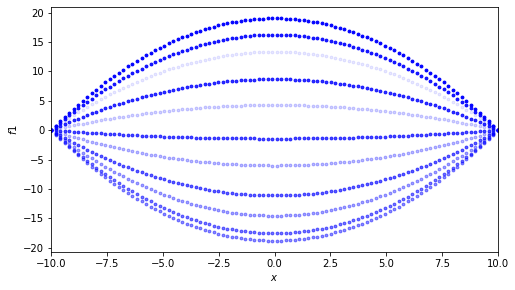

In [6]:
pt.pi = pt.acos(pt.zeros(1)).item()*2 # PyTorch has no built in Pi function

f1 = pt.multiply(20-0.2*pt.pow(Xm, 2), pt.exp(-0.05+2.3j*Tm)).T

plot_data(Xm[0,:], f1, 'f1.svg')

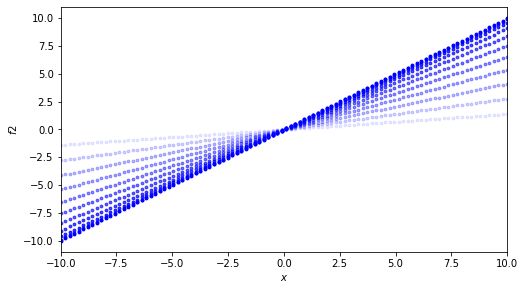

In [7]:
f2 = pt.multiply(Xm, pt.exp(0.6j*Tm)).T

plot_data(Xm[0,:], f2, 'f2.svg')

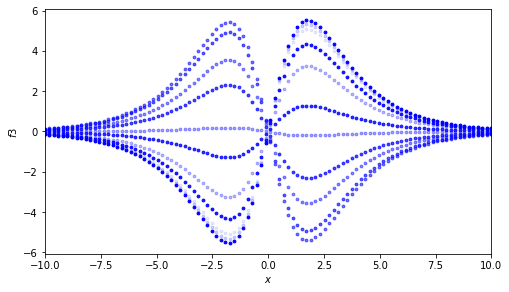

In [8]:
f3 = pt.multiply(10*pt.tanh(Xm/2)/pt.cosh(Xm/2), pt.exp(0.1+2.8j*Tm)).T

plot_data(Xm[0,:], f3, 'f3.svg')

### Combining Data:
The signals are combined into one data matrix. The individual modes remain recognizable.

Again: $t_0$ is darkest, with the opacity decreasing with time.

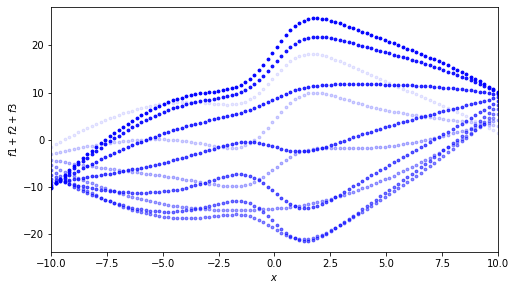

In [9]:
data = f1 + f2 + f3

plot_data(Xm[0,:], data, 'f1+f2+f3.svg')

#Create our two data snapshots X and X'
X = data[:,:-1]
X_prime = data[:,1:]

In [1]:
def plot_data(x, modes, path):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    for i in range(12):
        ax.scatter(x, pt.real(modes[:, i]), s=8, c='blue', alpha=1-(i/11))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel('${}$'.format(path[:-4]))
    ax.set_xlim(pt.min(x), pt.max(x))
    plt.show()
    #plt.savefig(path, bbox_inches="tight")

### Singular Value Decomposition (SVD)

The following function is defined to compute the SVD, the first step of DMD.

pt.svd() returns the reduced SVD by default, which might be necessary, depending on the size of the data. **is there an economy svd in pt? is this the same?**

*Note: torch.svd() is depricated. In torch 1.8, [torch.linalg.svd](https://pytorch.org/docs/1.8.0/linalg.html#torch.linalg.svd) will function like numpy.linalg.svd(), but this is not available in Version 1.7.1*

In [12]:
def svd(matrix, rank=None):
    '''
    Returns the singular value decomposition of data matrix.

            Parameters:
                    matrix (PyTorch.tensor(something))
            Returns:
                    U (unitary matrix): columns are called left singular vectors
                    s (tensor): real, nonnegative diagonal elements of Sigma
                    V (matrix): columns are called right singular vectors
    '''
    U, s, V = pt.svd(matrix, some=False)    #!! returns V, not V* !!
    if rank is None:
        rank = s.shape[0]
    return U[:, :rank], s[:rank], V[:, :rank]

#
U, s, V = svd(X)

### Truncating

Columns of U are the dominant coherant structures, or POD modes. For more on POD, check out the [POD notebook](POD_introduction.ipynb).

The diagonal elements of $\Sigma$ are singualar values, ordered from largest to smallest. We can easily graph these (small: $s \in \mathbb{C}^{m}$) to determine which ones are relevant to our data.

For this example, we can easily see that all of our data is represented by only 3 modes. We therefore keep 3 modes and to truncate the rest. This could potentially save us a lot of processing power during the following DMD steps.

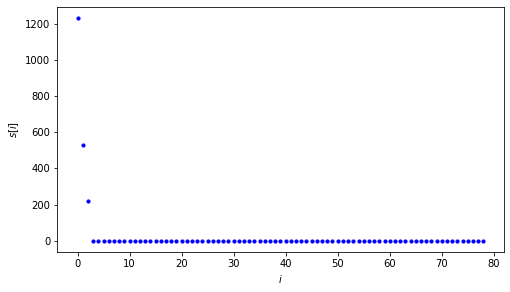

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
ax.set_ylabel('$s[i]$')
ax.set_xlabel('$i$')

plt.scatter(range(s.shape[0]), s, s=10, c='blue')
plt.show()

rank = 3 #truncate after first three modes

### Dynamic Mode Decomposition (DMD)

After finding the SVD of our matrix, we can find $\tilde{A} = U^*X'V\Sigma^{-1}$.

$\Sigma$ is a diagonal matrix and can therefore be inversed using 1/diag_elements.

After finding $\tilde{A}$, the eigenvalues and eigenvectors can be computed using pt.eig(). Since Pytorch does not currently support complex tensor operations (see [forum](https://discuss.pytorch.org/t/how-to-use-complex-eigenvalues/71983)), we will use np.linalg.eig() for this example.

Here $X=matrix[:,:-1]$ and $X'=matrix[:,1:]$, which is $X$ advanced one time step.

Finally, the eigenvectors of A $\Phi$ are computed and returned together with the eigenvalues (same for A and At). 

In [18]:
def dmd(matrix, rank=None):
    '''
    Returns the eigenvalues and eigenvectors of the data matrix.

            Parameters:
                    matrix (PyTorch.tensor(something)): contains snapshots of data X and X'
            Returns:
                    val (tensor): eigenvalues of data matrix
                    phi (tensor): eigenvectors (modes) of data matrix
    '''
    U, s, V = svd(matrix[:,:-1], rank)
    s_inv = pt.diag(1.0/s).type(pt.complex64) #type cast since Sigma is real (not necessary when using only real data)
    
    At = U.conj().T @ matrix[:, 1:] @ V @ s_inv #At = torch.mm(torch.mm(torch.mm(U.conj().T, matrix[:, 1:]), V), s_inv) not necessary because @ works too
    
    val, vec = np.linalg.eig(At)
    #val, vec = torch.eig(At, eigenvectors=True)
    
    phi = matrix[:, 1:] @ V @ s_inv @ vec
    return (val, phi)


val, phi = dmd(data, rank=rank) #rank=3 was determined from the POD-mode visualisation after calculating the SVD

# Split up steps of DMD with visuals

![SegmentLocal](f1_f2_f3.gif "segment")

## Questions:

- look at docstring notation in flowtorch/data/foamdataloader source code

## References

1. Kutz, J. N., Brunton, S. L. 1., Brunton, B. W., & Proctor, J. L. (2016). *Dynamic Mode Decomposition.* Philadelphia, PA, USA: Society for Industrial and Applied Mathematics.
2. Taylor, R. (2016) Dynamic Mode Decomposition in Python. *Pyrunner.* Accessed: 25 January 2021. http://www.pyrunner.com/weblog/2016/07/25/dmd-python/    

# Euler Data:

When only $Im$: $f_1(x) = (20-0.2x^2)e^{zt}, z=2.3j$

When $Re$ and $Im$: $f_1(x) = (20-0.2x^2)e^{zt}, z=-0.05 + 2.3j$

$f_1(x) = e^{-0.05t}(20-0.2x^2)e^{zt}, z=2.3j$

the amplitude of this is constantly decreasing.

# Test Cell:

tensor([9.0706e+02, 7.6914e+02, 4.5786e+02, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05, 4.9299e-05,
        4.9299e-05, 4.9299e-05, 4.9299e-

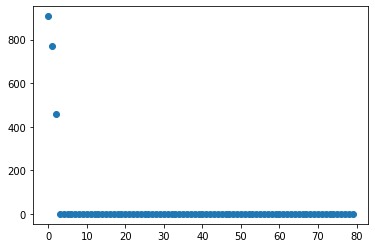

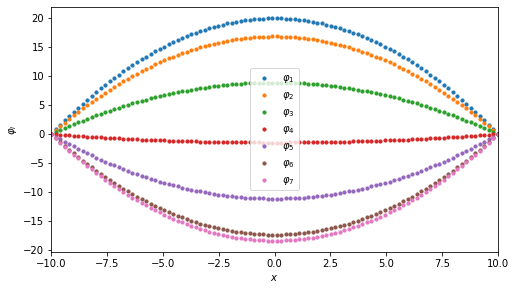

In [14]:
def plot_dmd_modes(x, modes, path):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    for i in range(modes.shape[1]):
        ax.scatter(x, pt.real(modes[:, i]), s=20, label=r"${:s}_{:d}$".format(r"{\varphi}", i+1))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"${\varphi}_i$")
    ax.set_xlim(pt.min(x), pt.max(x))
    ax.legend()
    plt.savefig(path, bbox_inches="tight")
    
def plot_data(x, modes, path):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    for i in range(7):
        ax.scatter(x, pt.real(modes[:, i]), s=10, label=r"${:s}_{:d}$".format(r"{\varphi}", i+1))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"${\varphi}_i$")
    ax.set_xlim(pt.min(x), pt.max(x))
    ax.legend()
    plt.savefig(path, bbox_inches="tight")
    
def animate_1D_sum(x, t, X, title, ylim, path):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    sc = []
    alpha = [0.1 for i in range(len(title))]
    alpha[0] = 1
    for i in range(len(title)):
        sc.append(ax.scatter([], [], s=10, label=title[i], alpha=alpha[i]))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$Re(f(x))$")
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(*ylim)
    text = ax.set_title(r"$t={:2.2f}$".format(t[0]))
    ax.legend(loc="upper right")
    movie = ani.FuncAnimation(
        fig, update_1D_plot, frames=len(t), fargs=(x, t, X, sc, text))
    writer = ani.FFMpegWriter(bitrate=500)
    movie.save(path, writer=writer)    
    
def main():
    Tm, Xm = create_mesh(-10, 10, 100, 0, 6*pt.pi, 80)
    X_1r = f1(Xm, Tm, -0.05+2.3j)
    X_2 = f2(Xm, Tm, 0.6j)
    X_3r = f3(Xm, Tm, 0.1+2.8j)
    data = X_1r + X_2 + X_3r

    rank=3
    #val, phi = dmd(data, rank=rank)
    
    #plot_dmd_modes(Xm[0,:], phi, "dmd_modes.svg")

if __name__ == "__main__":
    main()